# GEONE - Variogram analysis and kriging for data in 1D

Interpolate a data set in 1D, using simple or ordinary kriging. Starting from a data set in 1D, the following is done:

- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging (OK), simple kriging (SK)
- sequential gaussian simulation (SGS) based on ordinary or simple kriging

**Note:** most of the tools illustrated below can also be used for data in 2D or 3D assuming omni-directional covariance / variogram models.


## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.17


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Preparation - build a data set in 1D
A data set in 1D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define the *reference* covariance model in 1D (class `geone.covModel.CovModel1D`, see jupyter notebook `ex_grf_1d`).

In [3]:
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('spherical', {'w':7., 'r':100}),   # elementary contribution
    ('exponential', {'w':2.5, 'r':50}), # elementary contribution
    ('nugget', {'w':0.5})               # elementary contribution
    ], name='ref model')

In [4]:
cov_model_ref

*** CovModel1D object ***
name = 'ref model'
number of elementary contribution(s): 3
elementary contribution 0
    type: spherical
    parameters:
        w = 7.0
        r = 100
elementary contribution 1
    type: exponential
    parameters:
        w = 2.5
        r = 50
elementary contribution 2
    type: nugget
    parameters:
        w = 0.5
*****

Generate a gaussian random field in 1D (see function `geone.grf.grf1D`), and extract data points:

- `n`: number of data points
- `x`: location of data points (1-dimensional array of length `n`)
- `v`: values at data points (1-dimensional array of length `n`)

In [5]:
# Simulation grid (domain)
nx = 1000 # number of cells
sx = 0.5  # cell unit
ox = 0.0  # origin
# xmin, xmax = ox, ox + nx*sx # bounds of the simulation domain

# Reference simulation
np.random.seed(123)
ref = gn.grf.grf1D(cov_model_ref, nx, sx, ox, nreal=1) # 2d-array of shape 1 x nx

im_ref = gn.img.Img(nx, 1, 1, sx, 1., 1., ox, 0., 0., nv=1, val=ref) # fill image (Img class from geone.img) 

# Extract n points from the reference simulation
n = 25
# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = ps.x()
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x = x + (np.random.random(n)-0.5)* im_ref.sx
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iy=0, iz=0)
np.random.seed(987)
x = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
v = f(x)
# ----- #

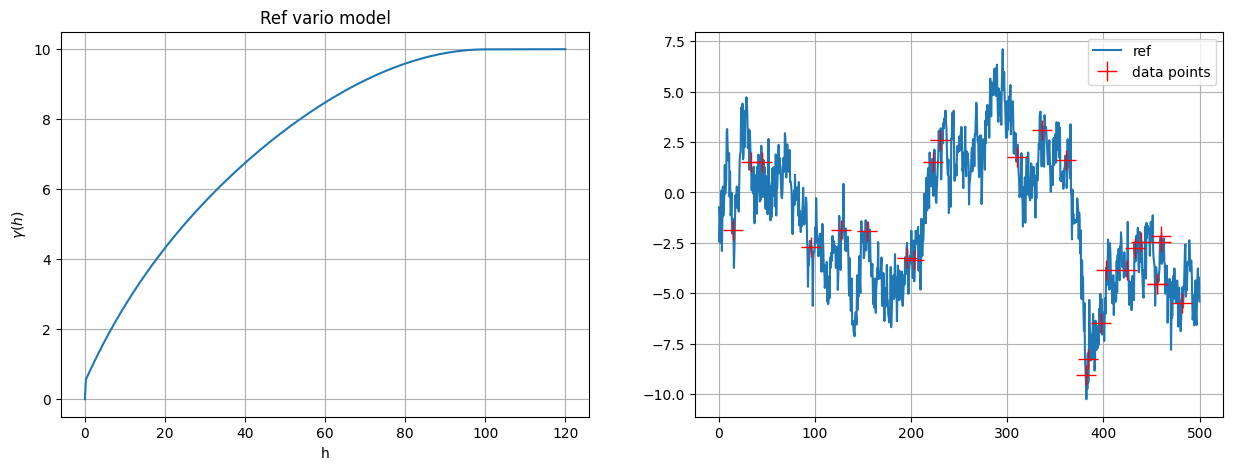

In [6]:
# Plot reference variogram model, reference simulation and data points
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
cov_model_ref.plot_model(vario=True)
plt.title('Ref vario model')

plt.subplot(1,2,2)
plt.plot(im_ref.x(), ref[0], label='ref')
plt.plot(x, v, 'r+', markersize=15, label='data points')
plt.grid()
plt.legend()
plt.show()

## Start from a data set in 1D

- `n`: number of data points
- `x`: 1-dimensional array of length `n`: locations of data points
- `v`: 1-dimensional array of length `n`: values at data points

Visualise the data set and the histogram of values.

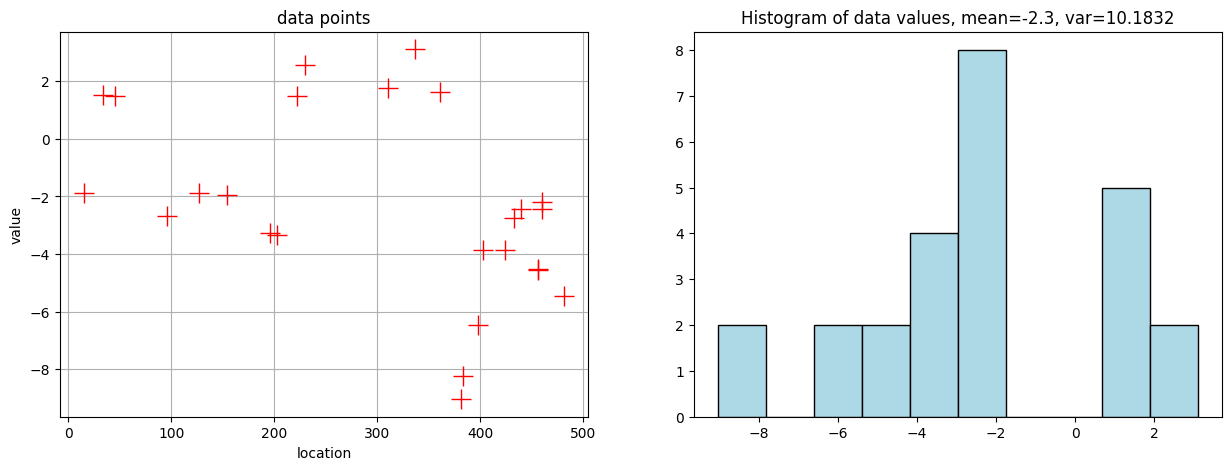

In [7]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x, v, 'r+', markersize=15)
plt.xlabel('location')
plt.ylabel('value')
plt.grid()
plt.title('data points')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram cloud
Compute the variogram cloud. The pair of the i-th and j-th data points gives the point $(h(i,j), g(i,j))$ in the variogram cloud, where

- $h(i,j) = \vert\vert x(i)-x(j)\vert\vert$ is the distance between $x(i)$ and $x(j)$ (lag)
- $g(i,j) = 1/2 \cdot (v(i)-v(j))^2)$ is the corresponding $\gamma$ value

The function `geone.covModel.variogramCloud1D` returns two 1-dimensional arrays `h` and `g` of same length `npair` containing the coordinates of the points in the variogram cloud. The maximal distance between two data points to be integrated in the variogram cloud can be specified by the keyword argument `hmax`. Note that a plot of the variogram cloud is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* variogram cloud.

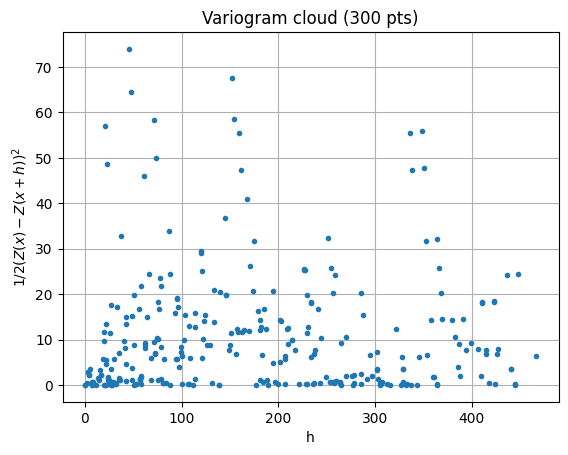

In [8]:
h, g, npair = gn.covModel.variogramCloud1D(x, v)

### Experimental variogram
Compute the experimental variogram. It is obtained from the variogram cloud by computing the mean points of variogram cloud points within vertical bands (classes for the lags). A class for a lag is an interval along the $h$-axis. 

The function `geone.covModel.variogramExp1D` returns three 1-dimensional arrays `hexp`, `gexp`, and `cexp` of same length (number of classes), where `hexp` and `gexp` contain the coordinates of the mean points of each class and `cexp` the number (counter) of points in each class.

The variogram cloud (if already computed) can be passed directly to the function `geone.covModel.variogramExp1D` via the keyword argument `geone.covModel.variogramCloud`: in this case, the arguments `x`, `v`, (and optional `hmax`) are not used. The classes can be defined in several ways: specifying the number of classes (`ncla`) / specifying the class centers (`cla_center`) / specifying the class length(s) (`cla_length`) (in particular overlapping classes are possible), see doc of the function). Note that a plot of the experimental variogram is made by default (keyword argument `make_plot=True`) with the counters displayed (keyword argument `show_count=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* experimental variogram.

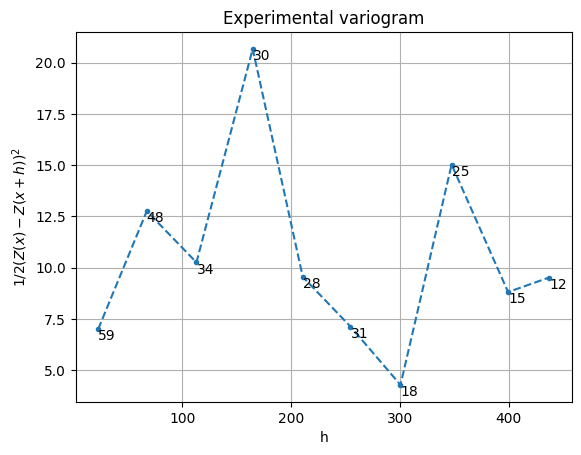

In [9]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 

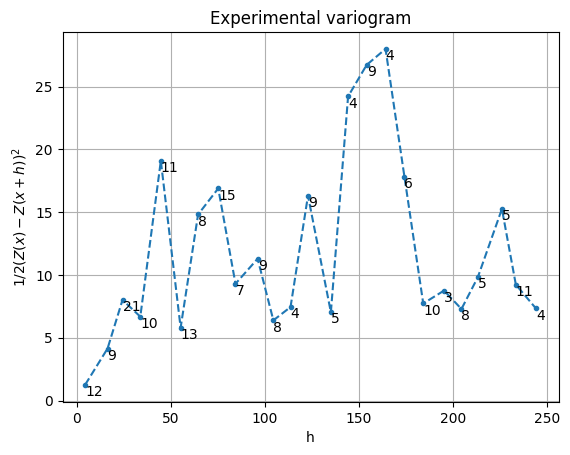

In [10]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=250, ncla=25)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, cla_center=np.arange(5, 250, 10))

Note that the function `geone.covModel.plot_variogramExp1D` allows to plot an experimental variogram (already computed): `geone.covModel.plot_variogramExp1D(hexp, gexp, cexp)` gives the plot above.

### Model fitting
The function `geone.covModelcovModel1D_fit` allows to fit a covariance / variogram model in 1D to given data.

This function takes as first argument the location of the data points, as second argument the values at the data points, and at third argument a covariance model in 1D with given type of elementary contributions and with parameters to fit set to `nan`. It returns the optimal covariance model and the vector of optimal parameters.

This function is based on the function `curve_fit` from `scipy.optimize` module. It fits the curve of the variogram model to the points $(h, \gamma(h))$, where $h$ is the lag between a pair of data points and $\gamma(h)$ is the half of the square of the difference of the values at these points (*i.e.* fit to the points of the variogram cloud). Hence, the fitting does not depend on the experimental variogram, *i.e.* on the choice of the classes for the lags.

The function `geone.covModelcovModel1D_fit` also takes the keyword argument `hmax`, which specifies the maximal distance between two data points to be integrated in the fitting. Note that a plot of the optimal model returned is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function fits an *omni-directional* model.

In [11]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
    ], name='')
try:
    cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize)
    plt.show()
except Exception as exc:
    print('ERROR:', exc)

ERROR: covModel1D_fit: fitting covariance model failed


#### Bounds for parameters to fit
Bounds for parameters to fit can be specified to avoid meaningless optimal parameters returned (*e.g.* negative weight or range). Such bounds are given to the function `geone.covModelcovModel1D_fit` (and then to the function `curve_fit` from `scipy.optimize`) via the keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)`, where the arrays of lower / upper bounds have the same length as the vector of parameters to fit, with the $i-$th entry corresponding to the $i$-th parameter to fit (set to `nan`) in the covariance model passed as third argument. Note also that the keyword argument `p0` allows to specify a vector of initial parameters (see doc of function `curve_fit`).

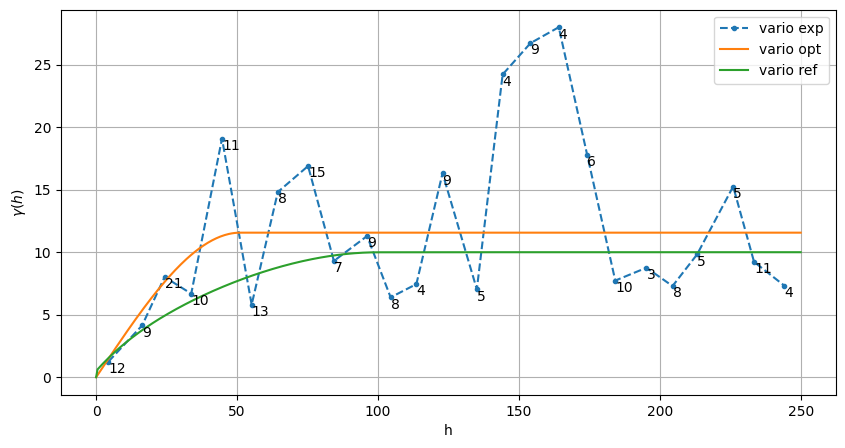

*** CovModel1D object ***
name = ''
number of elementary contribution(s): 4
elementary contribution 0
    type: gaussian
    parameters:
        w = 1.977162926740904e-06
        r = 50.18625558619614
elementary contribution 1
    type: spherical
    parameters:
        w = 11.563534937306773
        r = 51.10078843360831
elementary contribution 2
    type: exponential
    parameters:
        w = 3.838786585819951e-15
        r = 54.14259858412065
elementary contribution 3
    type: nugget
    parameters:
        w = 1.514837459635579e-08
*****

In [12]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
                ], name='')
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize,# hmax=300,
                                                 bounds=([ 0,   0,  0,   0,  0,   0,  0], 
                                                         [20, 300, 20, 300, 20, 300, 20]),
                                                 make_plot=False)
# bounds are given for:
#  index 0: parameter 'w' of gaussian contribution
#  index 1: parameter 'r' of gaussian contribution
#  index 2: parameter 'w' of spherical contribution
#  index 3: parameter 'r' of spherical contribution
#  index 4: parameter 'w' of exponential contribution
#  index 5: parameter 'r' of exponential contribution
#  index 6: parameter 'w' of nugget contribution

# Compare variogram exp. / variogram opt. / variogram ref
plt.figure(figsize=(10,5))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=250, ncla=25, label='vario exp') # equiv.
cov_model_opt.plot_model(vario=True, hmax=250, label='vario opt')
cov_model_ref.plot_model(vario=True, hmax=250, label='vario ref')
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` performs a cross-validation test by leave-one-out (LOO) error. Given a data set, a covariance model and a kriging interpolator, the kriging estimate $Z^*(x)$ and standard deviation $\sigma^*(x)$ are computed at each data point $x$, based on the data set without that data point $(x, Z(x))$ and the given covariance model.

The interpolator (function) used is passed by the keyword argument `interpolator` of the function `geone.covModel.cross_valid_loo`; the keyword argument `interpolator_kwargs` is a dictionary containing the keyword arguments that are passed to the function `interpolator`. By default:

- `interpolator=geone.covModel.krige`, `interpolator_kwargs=None`: the function `geone.covModel.krige` is used as interpolator with default parameters, *i.e.* simple_kriging is used with mean value at the data points taken into account (*i.e* without the removed data point)

To use ordinary kriging as interpolator, set `interpolator_kwargs={'method':'ordinary_kriging'}` (see below details about the function `geone.covModel.krige`).

The continuous rank probability score (CRPS) is computed for each data point $x$ and defined as
$\operatorname{crps}(F, x) = \int_{-\infty}^{+\infty} (F(y)-\mathcal{1}\{y\geqslant x\} dy$, where $F$ is the cumulative distribution function (CDF) of the prediction at $x$, i.e. in this case, $F$ is the CDF of a normal distribution of mean $Z^*(x)$ and variance ${\sigma^*}^2(x)$, $\mathcal{N}(Z^*(x), {\sigma^*}^2(x))$. A "default" CRPS, corresponding to the unbiased prediction (i.e. $Z^*(x)=Z(x)$) with a variance given by the variance of the data values, is also computed.

Two statisic tests are performed on the normalized error $errn(x) = (Z^*(x)-Z(x))/\sigma^*(x)$, which should approximately follows a standard normal distribution, $\mathcal{N}(0, 1)$. Let $n$ be the number of data points.

#### Normal law test for mean of normalized error
With $\operatorname{mean}(errn)=1/n\sum_i errn(x[i])$, the test computes:

- the p-value: $\mathbb{P}\left(\vert Z\vert \geqslant \vert\operatorname{mean}(errn)\vert\right)$, where $Z\sim\mathcal{N}(0, 1/n)$

#### Chi-square test for the sum of squares of normalized error
With $SSerrn = \sum_i errn(x[i])^2$,  the test computes:

- the p-value: $\mathbb{P}\left(X \geqslant SSern\right)$, where $X\sim\mathcal{\chi}^2_{n}$, the chi-square distribution with $n$ degrees of freedom

#### Interpretation
A low p-value (e.g. below a significance level $\alpha=5\%$) means that the model should be rejected (falsely rejected with probability $\alpha$): the smaller the p-value, the more evidence there is to reject the model. Each test computes the p-value and the result (success/failure): the boolean `success=(p-value > significance)`, which means that the model should be rejected when `success=False` with respect to the specified `significance` level.

#### Other statistics and plots
Specifying the keyword argument `print_result=True` (default), the function `geone.covModel.cross_valid_loo` prints the results of the statistics tests above, and some other statistics of the normalized error: the mean, standard deviation, skewness, excess kurtosis, to be compared with the standard normal distribution $\mathcal{N}(0,1)$.

Specifying the keyword argument `make_plot=True` (default), the function `geone.covModel.cross_valid_loo` displays some plots about the cross-validation. 

#### Returns
The function returns

- `cv_est`, `cv_std`: respectively the cross-validation estimates $Z^*(x)$ and standard deviation $\sigma^*(x)$ for every data point (sequence / array of length $n$)
- `crps`, `crps_def`: the CRPS for every data points (array `crps`), and the "default" CRPS (of the unbiased prediction with a variance given by the variance of the data values) (float `crps_def`)
- `pvalue`, `success`: respectively the p-values (floats) and the result (booleans) of each test (sequence of length $2$)


----- CRPS (negative; the larger, the better) -----
   mean = -0.8831
   def. = -0.7457
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.5641
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.9618
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = -0.1153 (should be close to 0)
   std      = 0.7393 (should be close to 1)
   skewness = -0.07056 (should be close to 0)
   excess kurtosis = -0.02039 (should be close to 0)


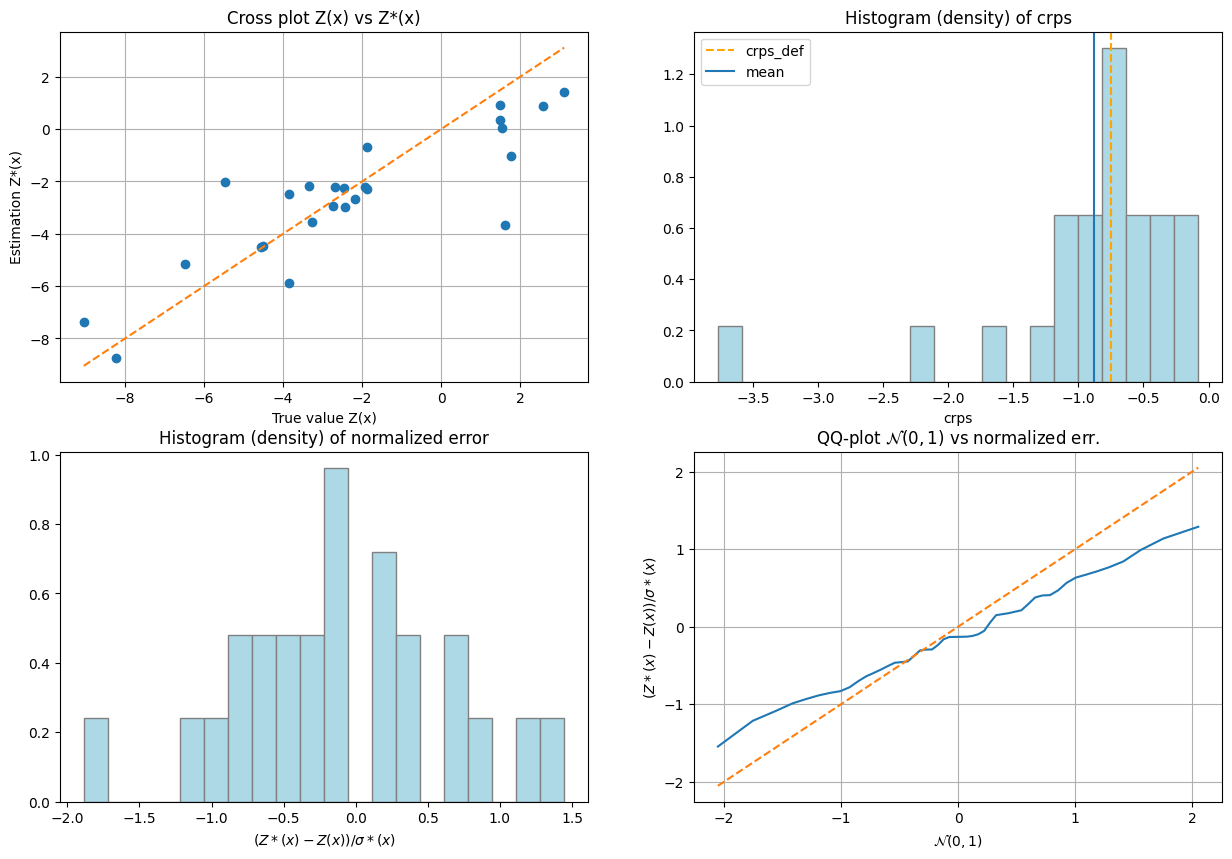

In [13]:
# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        # interpolator=gn.covModel.krige, #interpolator_kwargs={'mean':np.mean(v)},
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

----- CRPS (negative; the larger, the better) -----
   mean = -0.8893
   def. = -0.7457
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.9143
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.9811
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = -0.02152 (should be close to 0)
   std      = 0.7094 (should be close to 1)
   skewness = -0.2241 (should be close to 0)
   excess kurtosis = -0.03568 (should be close to 0)


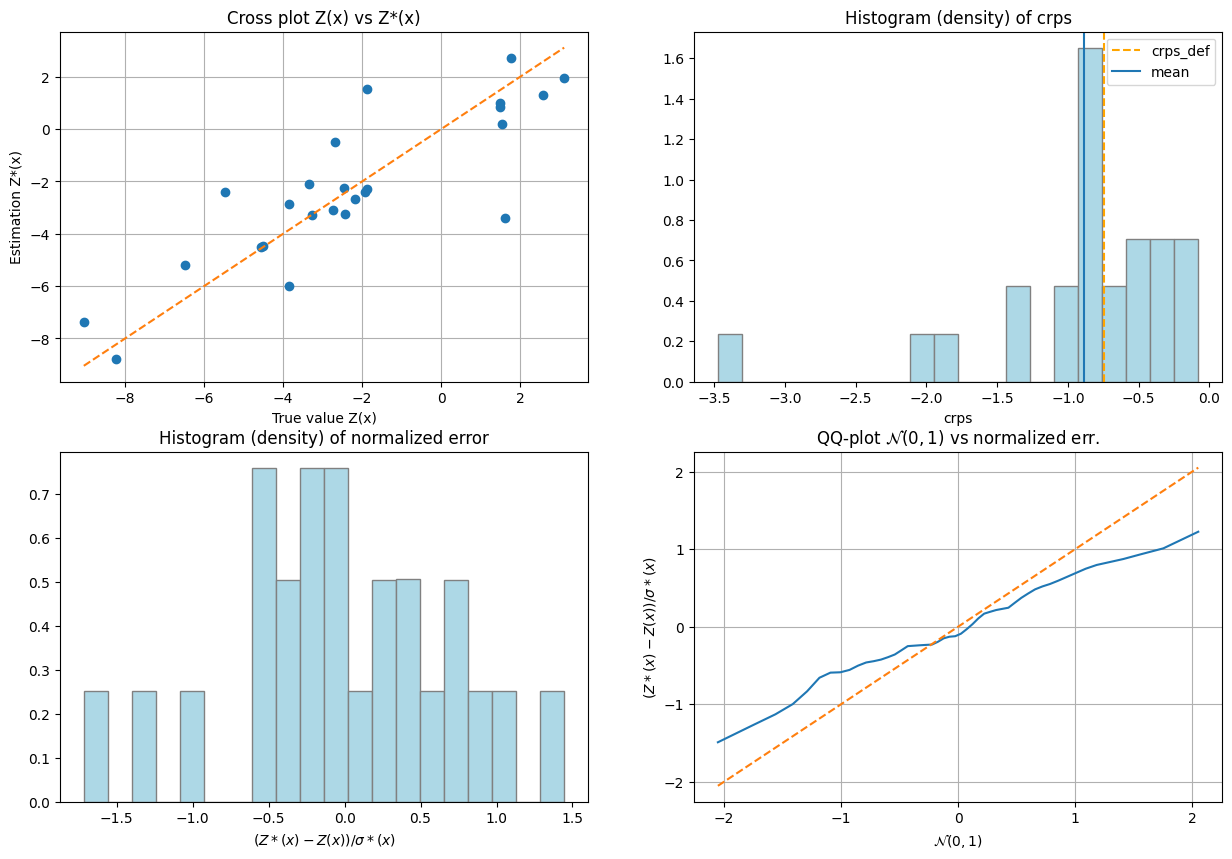

In [14]:
# Interpolation by ordinary kriging
cv_est2, cv_std2, crps2, crps_def2, pvalue2, success2 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, interpolator_kwargs={'method':'ordinary_kriging'},
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

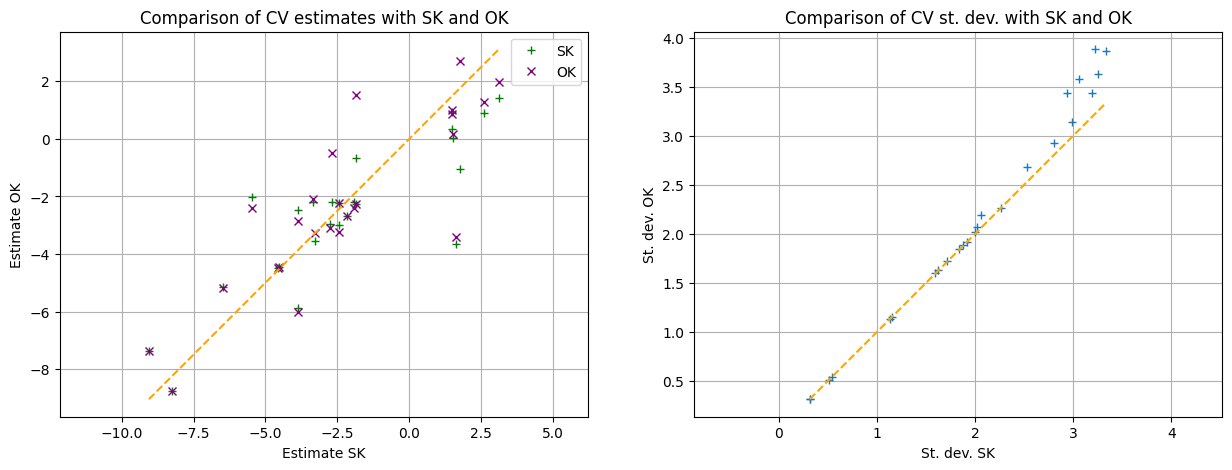

In [15]:
# Comparison of cross-validation with simple kriging and ordinary kriging
plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
# plt.plot(cv_est1, cv_est2, marker='+', ls='')
# plt.plot([np.min(cv_est1), np.max(cv_est1)], [np.min(cv_est1), np.max(cv_est1)], c='orange', ls='dashed')
# plt.axis('equal')
# plt.xlabel('Estimate SK')
# plt.ylabel('Estimate OK')
plt.plot(v, cv_est1, c='green', marker='+', ls='', label='SK')
plt.plot(v, cv_est2, c='purple', marker='x', ls='', label='OK')
plt.plot([np.min(v), np.max(v)], [np.min(v), np.max(v)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('Estimate SK')
plt.ylabel('Estimate OK')
plt.legend()
plt.grid()
plt.title('Comparison of CV estimates with SK and OK')

plt.subplot(1,2,2)
plt.plot(cv_std1, cv_std2, marker='+', ls='')
plt.plot([np.min(cv_std1), np.max(cv_std1)], [np.min(cv_std1), np.max(cv_std1)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('St. dev. SK')
plt.ylabel('St. dev. OK')
plt.title('Comparison of CV st. dev. with SK and OK')
plt.grid()
plt.show()

If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued. 

## Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
The function `geone.covModel.krige(x, v, xu, cov_model, method='simple_kriging', mean=None)` return the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Type of kriging is determined by the keyword argument `method`:

- `method='simple_kriging'` (default): simple kriging is used, with the mean automatically set to the mean of the data values (`mean=None`); a specified mean value or array (for non-stationary mean) can be set manually with the keyword argument `mean`
- `method='ordinary_kriging'`: ordinary kriging is used (the keyword argument `mean` must be `None` in this case)

Furthermore, the following parameters (keyword arguments) are available:

- `use_unique_neighborhood`: boolean
    - if `True`: kriging is done with a unique neighborhood (i.e. accounting for all data points)
    - if `False` (default): kriging is done by accounting for (a limited number of) data points within a search disk around the estimated point, see `dmax` and `nneighborMax` below
- `dmax` : float, radius of the search disk for kriging, only data points at a distance at max `dmax` from the estimated point will be taken into account; by default `dmax` is set to the range (max) of the covariance model
- `nneighborMax` : int (default: 12), maximal number of data points taken into account for kriging

For data in 1D:

- `x`: 2-dimensional array of shape `(n, 1)` or 1-dimensional array of length `n`, location of data points
- `v`: 1-dimensional array of length `n`, values at data points
- `xu`: 2-dimensional array of shape `(m, 1)` or 1-dimensional array of length `m`, location of points where the interpolation is done

In return:

- `vu`: 1-dimensional array of length `m`, kriging estimates at location `xu`
- `vu_std`: 1-dimensional array of length `m`, kriging standard deviation at location `xu`

**Note:** exact locations given by `x` and `xu` are kept (i.e. not migrated to the center of a grid cell).


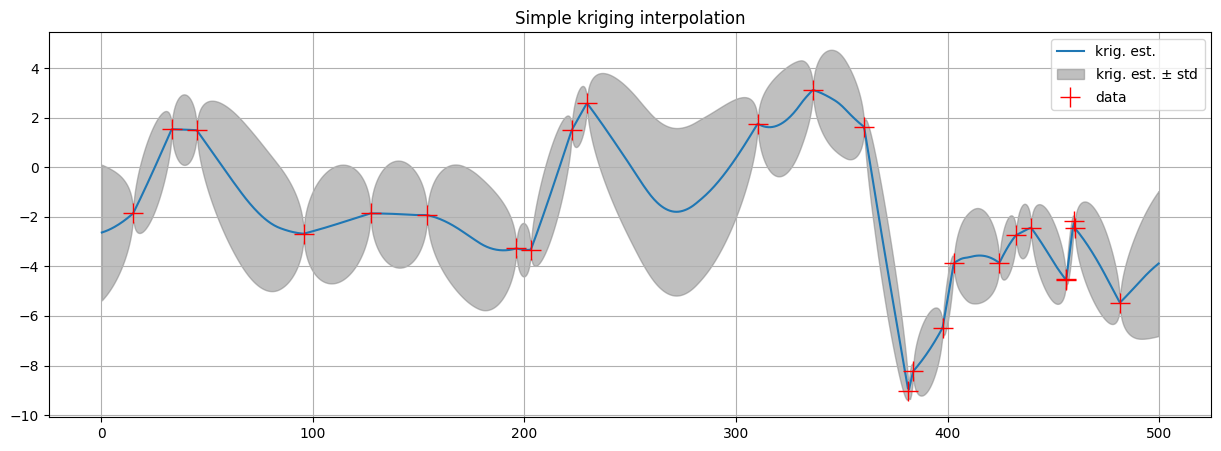

In [16]:
# Define points xu where to interpolate
# ... location of the 1D-grid used to build the data set (but it could be different)
xu = ox + (np.arange(nx)+0.5)*sx

# Simple kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Plot
plt.figure(figsize=(15,5))
plt.plot(xu, vu, label='krig. est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='gray', alpha=0.5, label=r'krig. est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.title('Simple kriging interpolation')
plt.show()

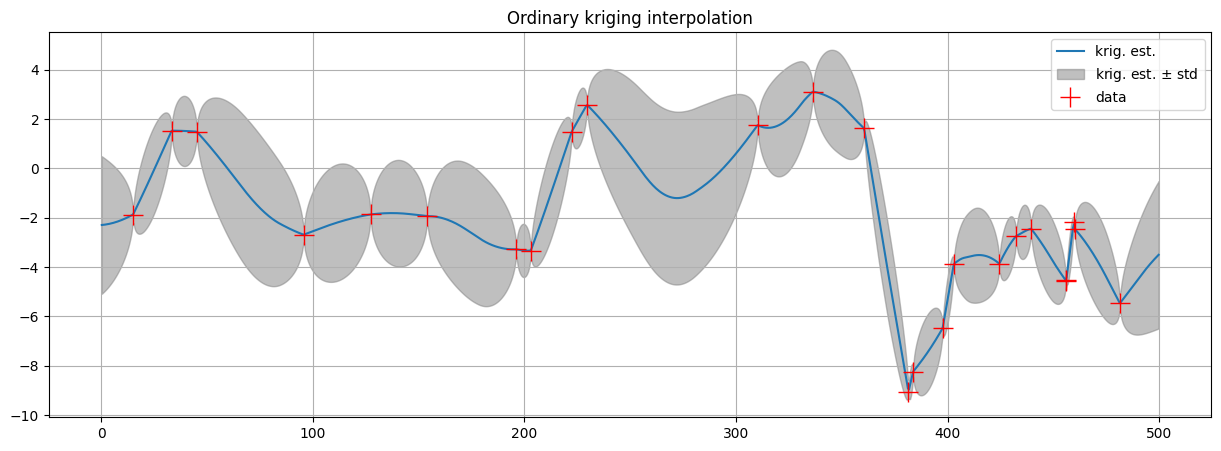

In [17]:
# Define points xu where to interpolate
# ... location of the 1D-grid used to build the data set (but it could be different)
xu = ox + (np.arange(nx)+0.5)*sx

# Ordinary kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='ordinary_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Plot
plt.figure(figsize=(15,5))
plt.plot(xu, vu, label='krig. est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='gray', alpha=0.5, label=r'krig. est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.title('Ordinary kriging interpolation')
plt.show()

## Simulation based on simple or ordinary kriging: function `geone.covModel.sgs`
The function `geone.covModel.sgs(x, v, xu, cov_model, method='simple_kriging', mean=None, nreal=1)` performs sequential gaussian simulation (SGS) based on simple or ordinary kriging, it returns realizations at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Simulation uses a limited neighorhood, i.e. a limited number of data points and previously simulated points are taken into account to solve the kriging system for simulating the value at a point, which is drawn in a normal law of mean equal to the kriged value and variance equal to the kriging variance. Type of kriging is determined by the keyword argument `method` as for the function `geone.covModel.krige` (see above).

The following parameters (keyword arguments) control the neighborhood for the simulation of each point:

- `dmax` : float, radius of the search disk for kriging system, only data points at a distance at max `dmax` from the estimated point will be taken into account; by default `dmax` is set to the range (max) of the covariance model
- `nneighborMax` : int (default: 12), maximal number of data points taken into account for kriging system

For data in 1D:

- `x`: 2-dimensional array of shape `(n, 1)` or 1-dimensional array of length `n`, location of data points
- `v`: 1-dimensional array of length `n`, values at data points
- `xu`: 2-dimensional array of shape `(m, 1)` or 1-dimensional array of length `m`, location of points where the simulation is done

In return:

- `vu`: 2-dimensional array of shape `(nreal, m)`, each row is a realization of the simulated values at `xu`

**Note:** exact locations given by `x` and `xu` are kept (i.e. not migrated to the center of a grid cell).

### Launching multiple processes for multi-realizations of SGS
The function `geone.covModel.sgs_mp` launches multiple processes, allowing to generate multiple realizations in parallel.

The function `geone.covModel.sgs_mp` has the same parameters as the function `geone.covModel.sgs`, plus the parameter `nproc`, which determines the number `n` of processes used (in parallel). If `nproc>0`, then `n = nproc`; if `nproc=-k<=0`, then `n = min(nmax-k, 1)`, where `nmax` is the total number of cpu(s) of the system (retrieved by `multiprocessing.cpu_count()`), i.e. all the cpus of the system except `k`, but at least 1, will be used. The set of realizations (specified by `nreal`) is then distributed in a balanced way over the processes.

Elapsed time: 0.51 sec


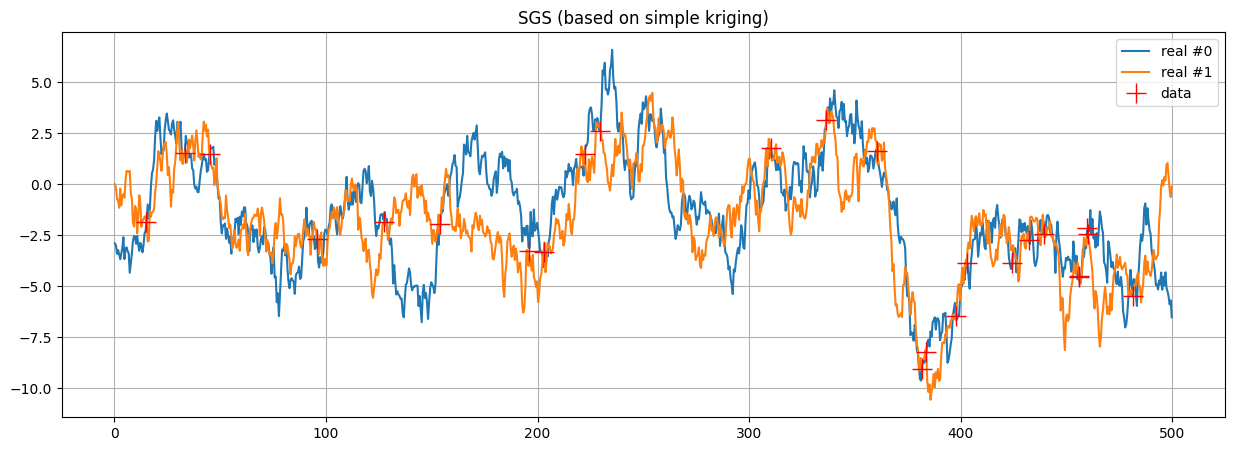

In [18]:
# Define points xu where to simulate
#sim_xu = ox + (np.arange(nx/2)+0.5)*2*sx # take less points for simulation
sim_xu = xu

# SGS based on simple kriging
nreal = 2
np.random.seed(321)
t1 = time.time()
sim_vu = gn.covModel.sgs(x, v, sim_xu, cov_model_opt, method='simple_kriging', nreal=nreal)  
# sim_vu:   2-dimensional array of shape (nreal, len(sim_xu)), each row is a realization 
#           (simulated values at locations sim_xu)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Plot
plt.figure(figsize=(15,5))
plt.plot(sim_xu, sim_vu[0], label='real #0')
plt.plot(sim_xu, sim_vu[1], label='real #1')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.title('SGS (based on simple kriging)')
plt.show()

## Alternatives for kriging estimation and simulation
The module `geone.geosclassicinterface` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_1d` for 1D case):

- function `geone.geosclassicinterface.estimate1D`: estimation in a 1D grid, *i.e.* kriging estimates and standard deviation, for simple or ordinary kriging
- function `geone.geosclassicinterface.simulate1D[_mp]`: simulation in a 1D grid, based on simple or ordinary kriging; allows also to handle inequality data

The module `geone.grf` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_grf_1d` for 1D case):

- function `geone.grf.krige1D`: estimation a 1D grid, *i.e.* kriging estimates and standard deviation, for simple kriging only
- function `geone.grf.grf1D`: simulation a 1D grid, based on simple kriging only

Note that for these functions, the conditioning values will be aggregated to (center of) grid cells containing the corresponding conditioning locations.

### Wrapper

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments:

- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate<d>D[_mp]`
- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate<d>D`
- `mode='simulation', algo='fft'`: wrapper for `geone.grf.grf<d>D`
- `mode='estimation', algo='fft'`: wrapper for `geone.grf.krige<d>D`

where the dimension `<d>` is automatically detected. Note also that the function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:

- `output_mode='array'`: an numpy array is returned
- `output_mode='img'`: an "image" (class `geone.img.Img`) is returned

Setting the keyword argument `use_multiprocessing=True`, the wrapper will launch the function `geone.geosclassicinterface.simulate<d>D_mp`, whereas with `use_multiprocessing=False` (default), it will launch the function `geone.geosclassicinterface.simulate<d>D`. If `use_multiprocessing=True`, it is recommended to also specify the number of parallel processes and the number of threads per process with the keyword arguments `nproc` and `nthreads_per_proc` respectively.

### Examples

### Estimation using the function `geone.covModel.krige`

In [19]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.0048 sec


### Estimation using the function `geone.grf.krige1D` 
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='fft'`.

In [20]:
t1 = time.time()
vu_grf, vu_std_grf = gn.multiGaussian.multiGaussianRun(cov_model_opt, nx, sx, ox, 
                                                       x=x, v=v,
                                                       mode='estimation', algo='fft', output_mode='array')
# # Or
# vu_grf, vu_std_grf = gn.grf.krige1D(cov_model_opt, nx, sx, ox, 
#                                     x=x, v=v)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krige1D: Computing circulant embedding...
krige1D: embedding dimension: 2048
krige1D: Computing FFT of circulant matrix...
krige1D: Computing covariance matrix (rAA) for conditioning locations...
krige1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige1D: Computing rBA * rAA^(-1)...
krige1D: computing kriging estimates...
krige1D: computing kriging standard deviation ...
Elapsed time: 0.013 sec


### Estimation using the function `geone.geosclassicinterface.estimate1D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='classic'`.

In [21]:
t1 = time.time()
vu_gci, vu_std_gci = gn.multiGaussian.multiGaussianRun(cov_model_opt, nx, sx, ox, x=x, v=v,
                                                       mode='estimation', algo='classic', output_mode='array',
                                                       method='simple_kriging', use_unique_neighborhood=True,
                                                       nthreads=8)
# # Or
# estim_gci = gn.geosclassicinterface.estimate1D(cov_model_opt, nx, sx, ox, 
#                                                x=x, v=v, 
#                                                method='simple_kriging', use_unique_neighborhood=True)
# vu_gci, vu_std_gci = estim_gci['image'].val[:,0,0,:]
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

estimate1D: Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
estimate1D: Geos-Classic run complete
Elapsed time: 0.0081 sec


### Plot results of estimation

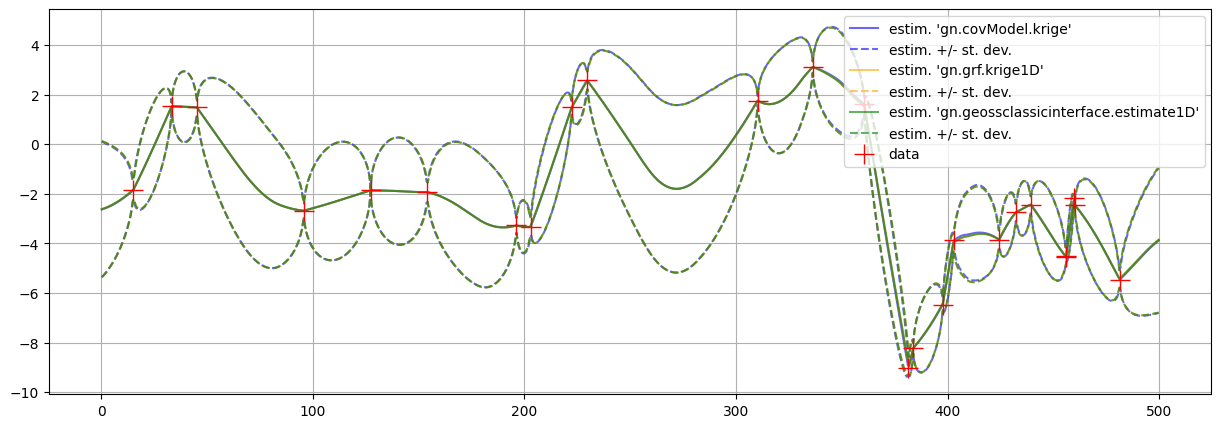

In [22]:
# Plot
plt.figure(figsize=(15,5))
plt.plot(xu, vu, color='blue', ls='solid', alpha=.6, label="estim. 'gn.covModel.krige'")
plt.plot(xu, vu + vu_std, color='blue', ls='dashed', alpha=.6, label='estim. +/- st. dev.')
plt.plot(xu, vu - vu_std, color='blue', ls='dashed', alpha=.6)

plt.plot(xu, vu_grf, color='orange', ls='solid', alpha=.6, label="estim. 'gn.grf.krige1D'")
plt.plot(xu, vu_grf + vu_std_grf, color='orange', ls='dashed', alpha=.6, label='estim. +/- st. dev.')
plt.plot(xu, vu_grf - vu_std_grf, color='orange', ls='dashed', alpha=.6)

plt.plot(xu, vu_gci, color='green', ls='solid', alpha=.6, label="estim. 'gn.geossclassicinterface.estimate1D'")
plt.plot(xu, vu_gci + vu_std_gci, color='green', ls='dashed', alpha=.6, label='estim. +/- st. dev.')
plt.plot(xu, vu_gci - vu_std_gci, color='green', ls='dashed', alpha=.6)

plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.show()

In [23]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige1D'                     = {}".format(np.ptp(vu - vu_grf)))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu - vu_gci)))
print("Peak-to-peak estimation 'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu_grf - vu_gci)))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige1D'                     = {}".format(np.ptp(vu_std - vu_std_grf)))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu_std - vu_std_gci)))
print("Peak-to-peak st. dev.   'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = {}".format(np.ptp(vu_std_grf - vu_std_gci)))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige1D'                     = 0.33881039153231907
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = 0.3391661323871573
Peak-to-peak estimation 'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = 0.00932574195458935
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige1D'                     = 0.27318484822178024
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate1D' = 0.2731848482217941
Peak-to-peak st. dev.   'gn.grf.krige1D    - gn.geosclassicinterface.estimate1D' = 1.8262330998830567e-05


### Conditional simulation using the function `geone.grf.grf1D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='fft'`.

In [24]:
np.random.seed(293)

t1 = time.time()
nreal = 2000
sim_grf = gn.multiGaussian.multiGaussianRun(cov_model_opt, nx, sx, ox, 
                                            x=x, v=v,
                                            mode='simulation', algo='fft', output_mode='array',
                                            nreal=nreal)
# # Or:
# sim_grf = gn.grf.grf1D(cov_model_opt, nx, sx, ox, 
#                        x=x, v=v, 
#                        nreal=nreal)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

grf1D: Preliminary computation...
grf1D: Computing circulant embedding...
grf1D: embedding dimension: 2048
grf1D: Computing FFT of circulant matrix...
grf1D: Treatment of conditioning data...
grf1D: Computing covariance matrix (rAA) for conditioning locations...
grf1D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 8.6 sec


### Conditional simulation using the function `geone.geosclassicinterface.simulate1D_mp`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='classic'`, and `use_multiprocessing=True` (and also specifying `nproc` and `nthreads_per_proc`).

In [25]:
np.random.seed(293)

t1 = time.time()
nreal = 2000
sim_gci = gn.multiGaussian.multiGaussianRun(cov_model_opt, nx, sx, ox, 
                                            x=x, v=v,
                                            mode='simulation', algo='classic', output_mode='array',
                                            nreal=nreal, method='simple_kriging',
                                            use_multiprocessing=True, nproc=2, nthreads_per_proc=4)
# # Or:
# sim_gci = gn.geosclassicinterface.simulate1D_mp(cov_model_opt, nx, sx, ox, 
#                                                 x=x, v=v, 
#                                                 nreal=nreal, method='simple_kriging', 
#                                                 nproc=2, nthreads_per_proc=4)
# sim_gci = sim_gci['image'].val[:,0,0,:]
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simulate1D_mp: Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
simulate1D_mp: Geos-Classic run complete (all process(es))
Elapsed time: 7.9 sec


### Plot some realizations and compare to the reference simulation

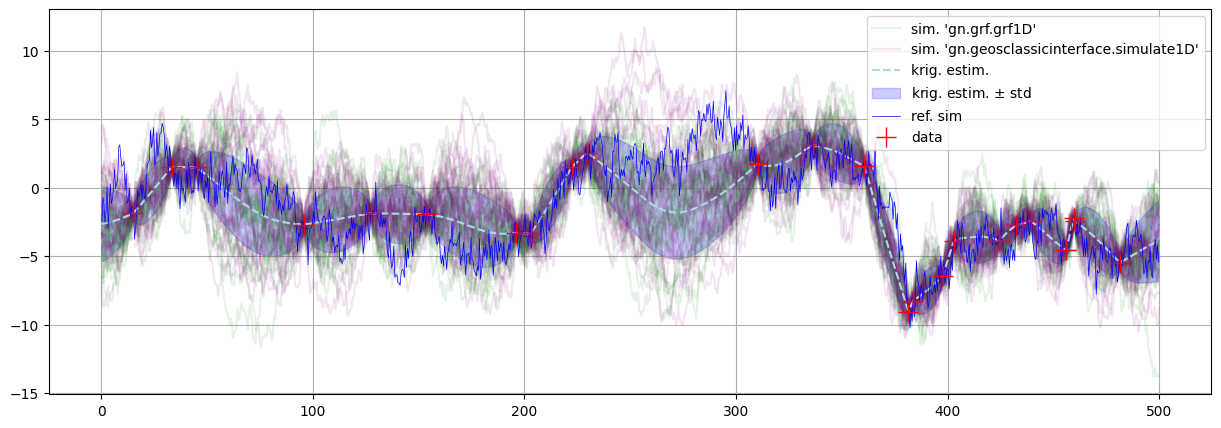

In [26]:
# Plot
plt.figure(figsize=(15,5))
for i in range(30):
    if i == 0:
        label = "sim. 'gn.grf.grf1D'"
    else:
        label = None
    plt.plot(xu, sim_grf[i], color='green', alpha=.1, label=label)
for i in range(30):
    if i == 0:
        label = "sim. 'gn.geosclassicinterface.simulate1D'"
    else:
        label = None
    plt.plot(xu, sim_gci[i], color='purple', alpha=.1, label=label)
plt.plot(xu, vu, color='lightblue', ls='dashed', label='krig. estim.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='blue', alpha=0.2, label=r'krig. estim. $\pm$ std')
plt.plot(xu, ref[0], color='blue', lw=.5, label='ref. sim')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.show()